Using device: cpu
Training samples: 1600
Validation samples: 400
Vocabulary size: 1002
Model parameters: 139,650
Epoch 1/10
  Train Loss: 0.2280, Train Acc: 0.9450
  Val Loss: 0.1990, Val Acc: 0.9350
--------------------------------------------------
Epoch 2/10
  Train Loss: 0.1562, Train Acc: 0.9500
  Val Loss: 0.1935, Val Acc: 0.9350
--------------------------------------------------
Epoch 3/10
  Train Loss: 0.1531, Train Acc: 0.9500
  Val Loss: 0.2094, Val Acc: 0.9350
--------------------------------------------------
Epoch 4/10
  Train Loss: 0.1382, Train Acc: 0.9500
  Val Loss: 0.1896, Val Acc: 0.9350
--------------------------------------------------
Epoch 5/10
  Train Loss: 0.1314, Train Acc: 0.9500
  Val Loss: 0.1877, Val Acc: 0.9350
--------------------------------------------------
Epoch 6/10
  Train Loss: 0.1266, Train Acc: 0.9500
  Val Loss: 0.1919, Val Acc: 0.9350
--------------------------------------------------
Epoch 7/10
  Train Loss: 0.1268, Train Acc: 0.9500
  Val Lo

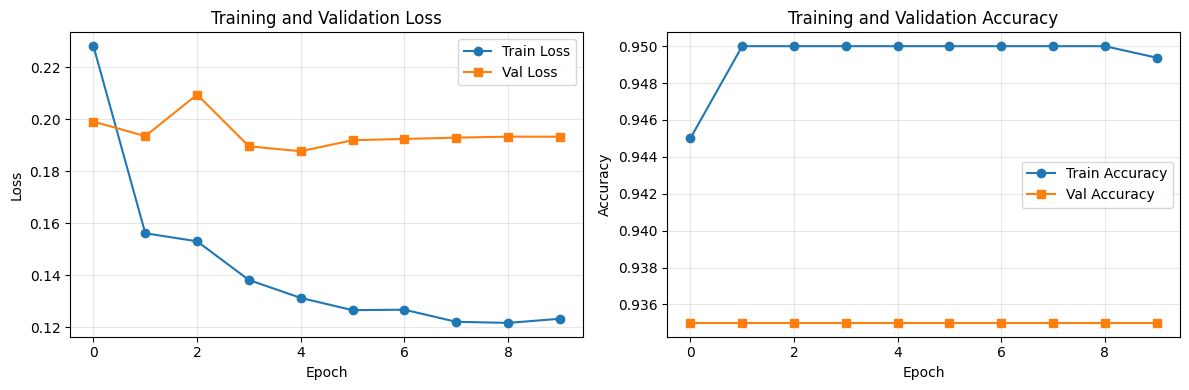

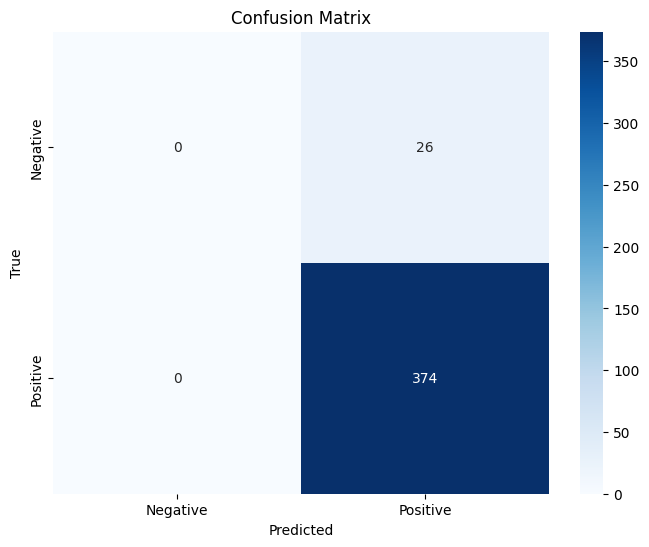

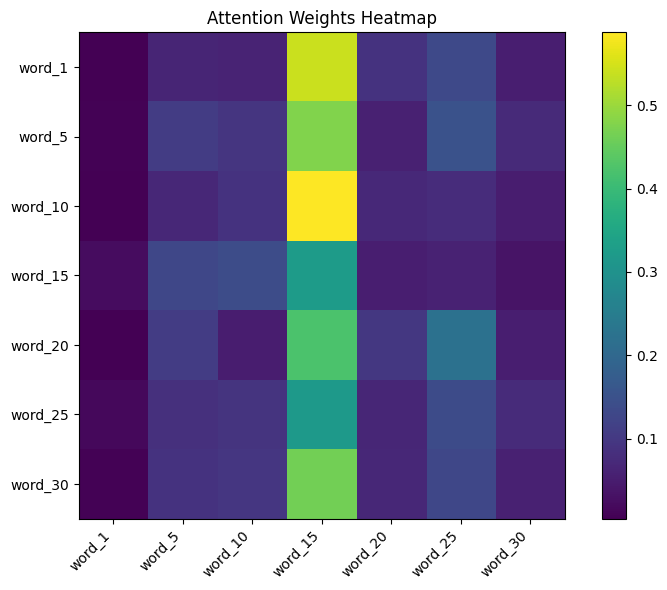

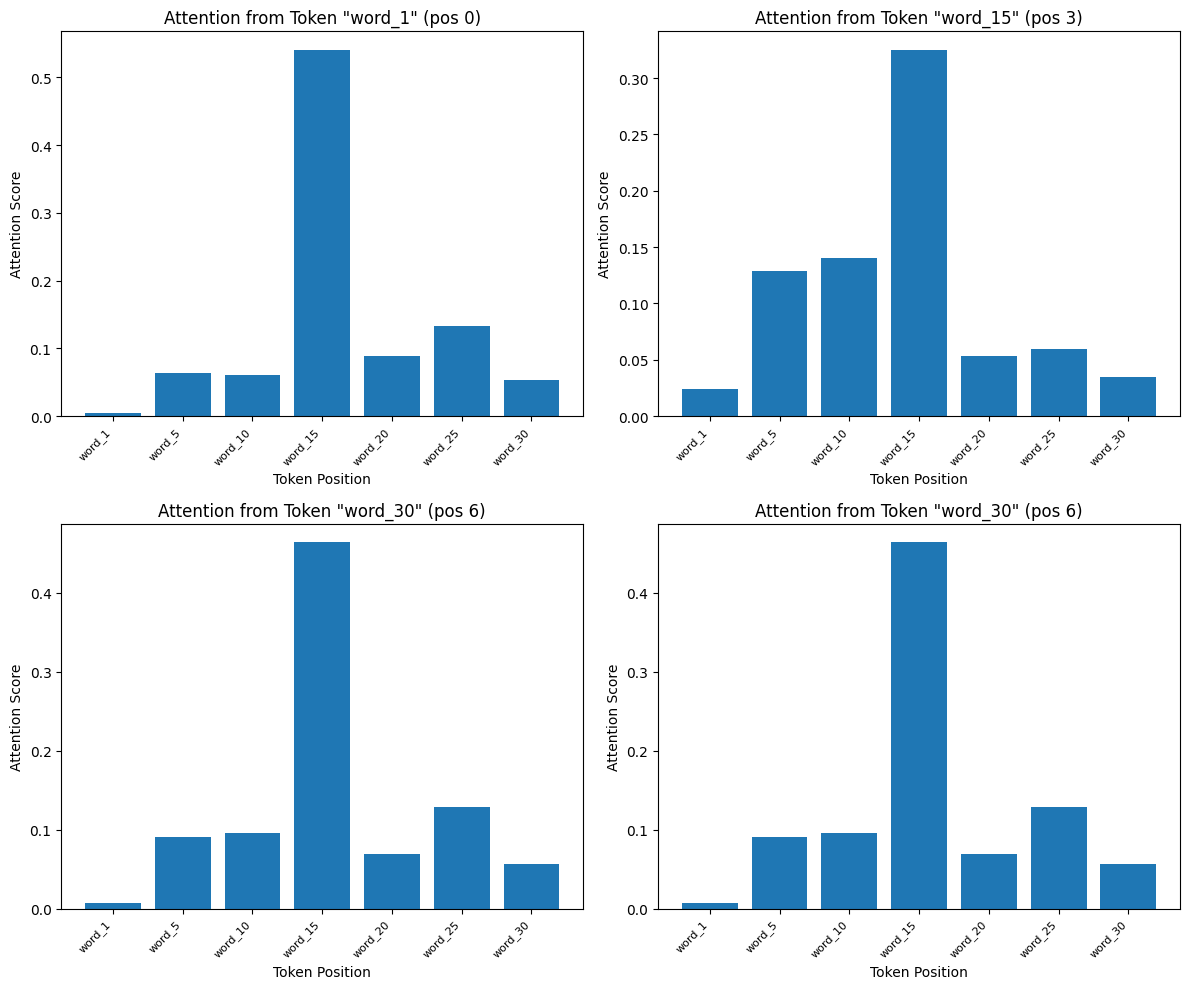

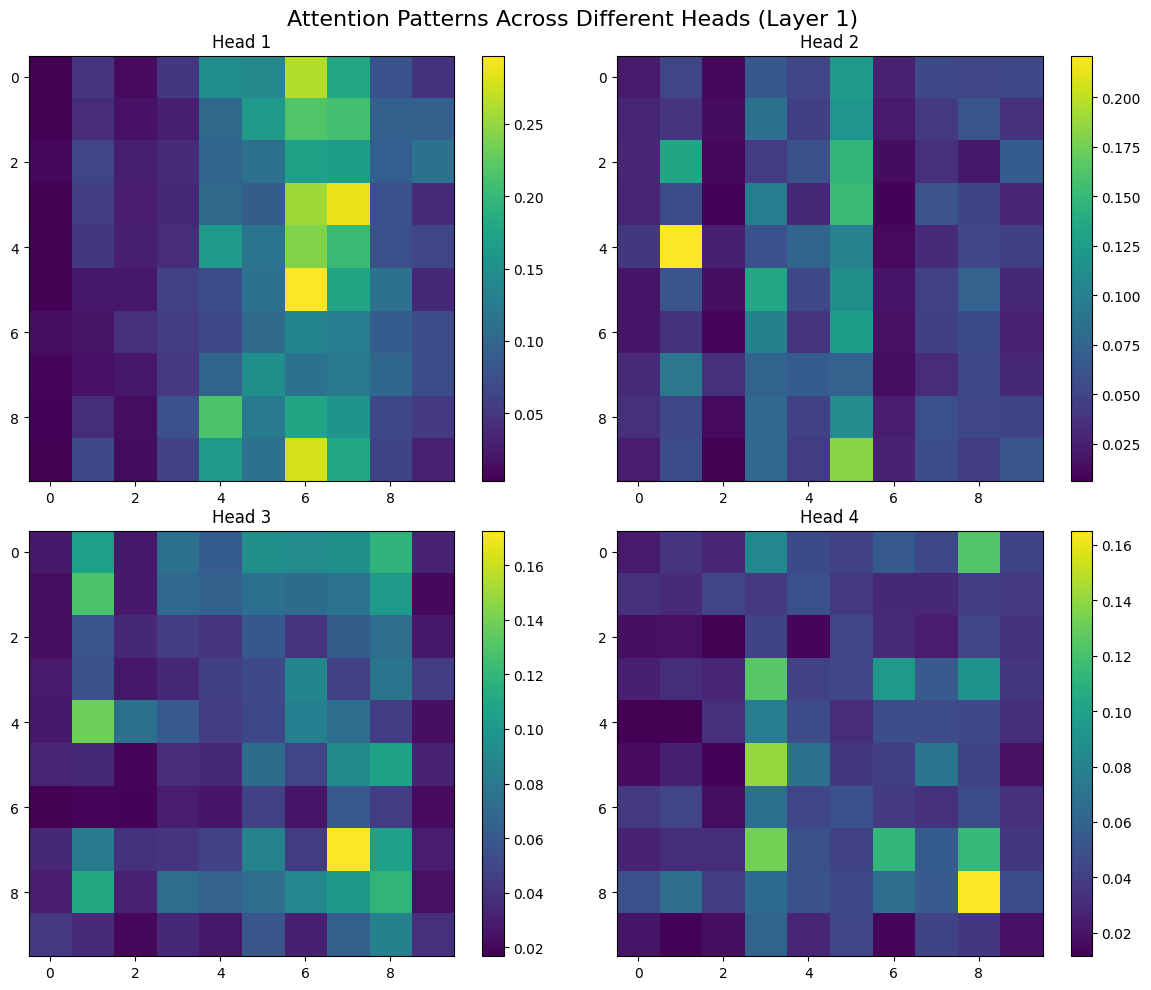

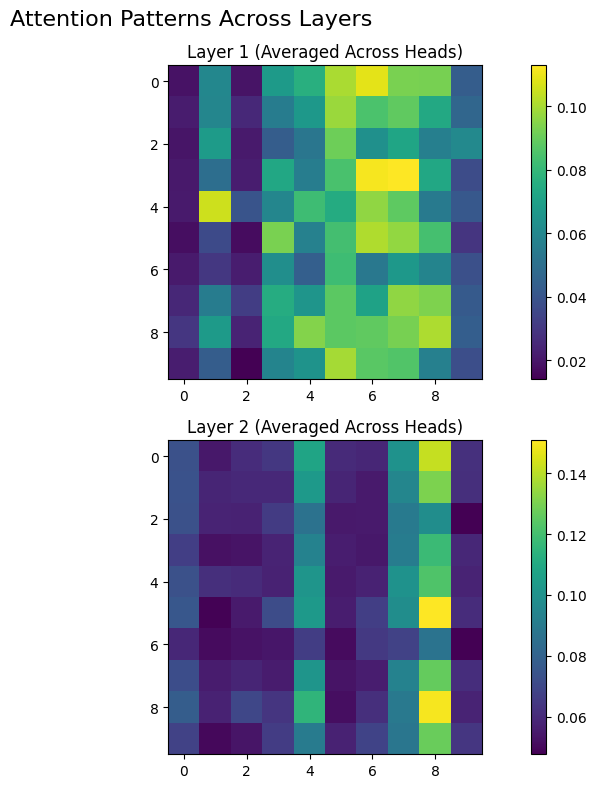

Model Performance Analysis:
Overall Accuracy: 0.9350

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        26
    Positive       0.94      1.00      0.97       374

    accuracy                           0.94       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.87      0.94      0.90       400



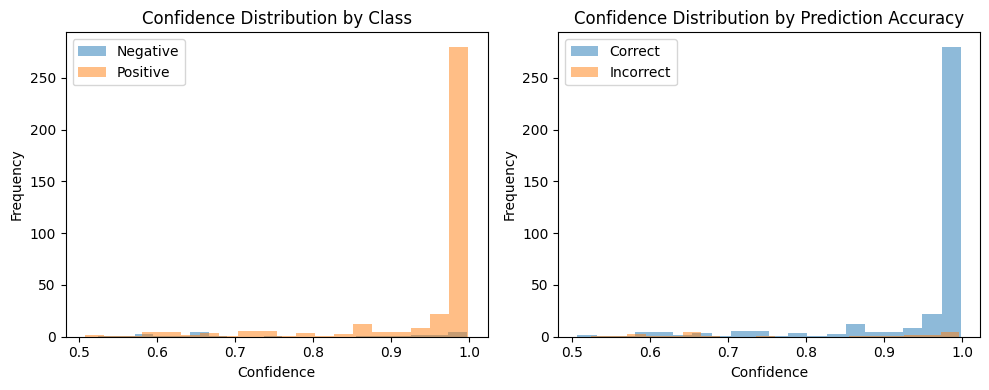

Ablation Study: Effect of Number of Attention Heads

Training with 1 attention head(s)...
----------------------------------------
Final Validation Accuracy: 0.9350
Number of parameters: 139,650

Training with 2 attention head(s)...
----------------------------------------
Final Validation Accuracy: 0.9350
Number of parameters: 139,650

Training with 4 attention head(s)...
----------------------------------------
Final Validation Accuracy: 0.9350
Number of parameters: 139,650

Training with 8 attention head(s)...
----------------------------------------
Final Validation Accuracy: 0.9350
Number of parameters: 139,650


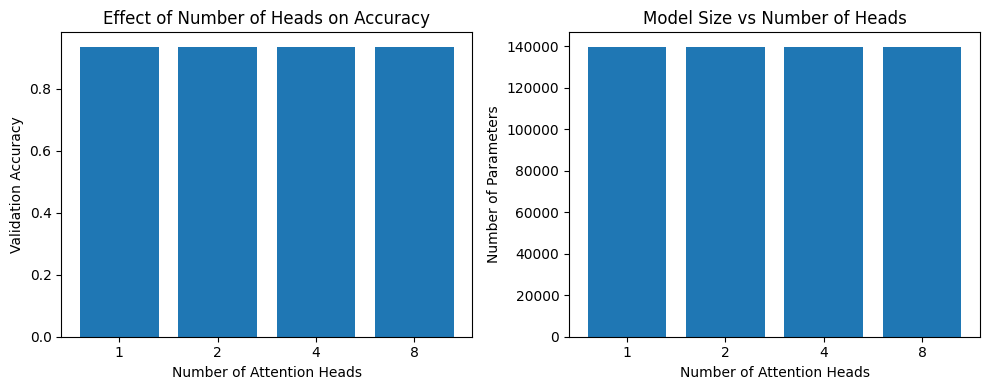

Model saved to transformer_model.pth
Inference Examples:
Text: word_1 word_5 word_10
  Sentiment: Positive
  Confidence: 0.5163
  Probabilities: [Negative: 0.4837, Positive: 0.5163]
----------------------------------------
Text: word_100 word_200 word_300
  Sentiment: Positive
  Confidence: 0.5453
  Probabilities: [Negative: 0.4547, Positive: 0.5453]
----------------------------------------
Text: word_1 word_200 word_10
  Sentiment: Positive
  Confidence: 0.5179
  Probabilities: [Negative: 0.4821, Positive: 0.5179]
----------------------------------------
Text: word_5 word_10 word_15
  Sentiment: Positive
  Confidence: 0.5856
  Probabilities: [Negative: 0.4144, Positive: 0.5856]
----------------------------------------
Tutorial Summary

Key Takeaways:
1. Self-attention allows parallel processing of sequences
2. Multi-head attention captures different types of relationships
3. Positional encoding adds sequence order information
4. Transformer models scale well with more data and paramet

In [1]:
# %% [markdown]
# # Self-Attention and Transformers Tutorial
#
# Complete implementation with training, visualization, and real dataset examples

# %% [markdown]
# ## 1. Setup and Imports

# %%
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Complete Self-Attention Implementation

# %%
class MultiHeadSelfAttention(nn.Module):
    """
    Complete multi-head self-attention implementation
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Query, Key, Value projections for all heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Scaling factor
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len, embed_dim = x.shape

        # Linear projections
        Q = self.q_proj(x)  # [batch_size, seq_len, embed_dim]
        K = self.k_proj(x)  # [batch_size, seq_len, embed_dim]
        V = self.v_proj(x)  # [batch_size, seq_len, embed_dim]

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        output = torch.matmul(attention_weights, V)

        # Reshape back
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        # Final linear projection
        output = self.out_proj(output)

        if return_attention:
            return output, attention_weights
        return output

# %% [markdown]
# ## 3. Transformer Encoder Layer

# %%
class TransformerEncoderLayer(nn.Module):
    """
    Complete transformer encoder layer with layer normalization and feed-forward network
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        # Multi-head self-attention
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None, return_attention=False):
        # Self-attention with residual connection
        if return_attention:
            attn_output, attention_weights = self.self_attn(x, mask, return_attention=True)
        else:
            attn_output = self.self_attn(x, mask)

        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed-forward with residual connection
        ff_output = self.ffn(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        if return_attention:
            return x, attention_weights
        return x

# %% [markdown]
# ## 4. Complete Transformer Model for Text Classification

# %%
class TransformerClassifier(nn.Module):
    """
    Complete transformer model for text classification
    """
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers,
                 ff_dim, max_seq_len, num_classes, dropout=0.1):
        super().__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len

        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        # Positional encoding
        self.positional_encoding = self.create_positional_encoding(max_seq_len, embed_dim)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def create_positional_encoding(self, max_len, d_model):
        """Create sinusoidal positional encodings"""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len = x.shape

        # Create token embeddings
        token_embeds = self.token_embedding(x)

        # Add positional encoding
        pos_encoding = self.positional_encoding[:, :seq_len, :].to(x.device)
        x = token_embeds + pos_encoding
        x = self.dropout(x)

        # Pass through encoder layers
        attention_weights_list = []
        for encoder_layer in self.encoder_layers:
            if return_attention:
                x, attn_weights = encoder_layer(x, mask, return_attention=True)
                attention_weights_list.append(attn_weights)
            else:
                x = encoder_layer(x, mask)

        # Global average pooling
        x = x.mean(dim=1)

        # Classification
        logits = self.classifier(x)

        if return_attention:
            return logits, attention_weights_list
        return logits

# %% [markdown]
# ## 5. Dataset Loading and Preprocessing

# %%
# Let's use the IMDB dataset for sentiment analysis
# First, we'll create a simple dataset class

class TextDataset(Dataset):
    """Dataset for text classification"""
    def __init__(self, texts, labels, vocab, max_seq_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Convert text to indices
        tokens = text.lower().split()[:self.max_seq_len]
        indices = [self.vocab.get(token, self.vocab['<UNK>'])
                  for token in tokens]

        # Pad sequence
        if len(indices) < self.max_seq_len:
            indices += [self.vocab['<PAD>']] * (self.max_seq_len - len(indices))
        else:
            indices = indices[:self.max_seq_len]

        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# %% [markdown]
# ## 6. Create Synthetic Dataset (for demonstration)

# %%
def create_synthetic_dataset(num_samples=2000, max_seq_len=32, vocab_size=1000):
    """Create a synthetic dataset for demonstration"""

    # Create vocabulary
    vocab = {f'word_{i}': i for i in range(vocab_size)}
    vocab['<PAD>'] = vocab_size
    vocab['<UNK>'] = vocab_size + 1

    texts = []
    labels = []

    for _ in range(num_samples):
        # Generate random text
        seq_len = np.random.randint(5, max_seq_len)
        words = [f'word_{np.random.randint(0, vocab_size)}'
                for _ in range(seq_len)]
        text = ' '.join(words)

        # Simple rule for labels: if contains specific patterns
        label = 1 if any(f'word_{i}' in text for i in [1, 5, 10]) else 0

        texts.append(text)
        labels.append(label)

    return texts, labels, vocab

# Create dataset
texts, labels, vocab = create_synthetic_dataset()

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create datasets
max_seq_len = 32
train_dataset = TextDataset(train_texts, train_labels, vocab, max_seq_len)
val_dataset = TextDataset(val_texts, val_labels, vocab, max_seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Vocabulary size: {len(vocab)}")

# %% [markdown]
# ## 7. Initialize Model and Training Setup

# %%
# Model parameters
vocab_size = len(vocab)
embed_dim = 64
num_heads = 4
num_layers = 2
ff_dim = 128
num_classes = 2
dropout = 0.1

# Initialize model
model = TransformerClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ff_dim=ff_dim,
    max_seq_len=max_seq_len,
    num_classes=num_classes,
    dropout=dropout
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# %% [markdown]
# ## 8. Training Loop

# %%
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    attention_weights_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Metrics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels

# %% [markdown]
# ## 9. Training Execution

# %%
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)

# %% [markdown]
# ## 10. Visualization Functions

# %%
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot losses
    axes[0].plot(train_losses, label='Train Loss', marker='o')
    axes[0].plot(val_losses, label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracies
    axes[1].plot(train_accuracies, label='Train Accuracy', marker='o')
    axes[1].plot(val_accuracies, label='Val Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_attention_weights(model, sample_text, vocab, max_seq_len, device):
    """Visualize attention weights for a sample text"""
    model.eval()

    # Preprocess text
    tokens = sample_text.lower().split()[:max_seq_len]
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Pad sequence
    if len(indices) < max_seq_len:
        indices += [vocab['<PAD>']] * (max_seq_len - len(indices))

    # Convert to tensor
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)

    # Get attention weights
    with torch.no_grad():
        _, attention_weights = model(input_tensor, return_attention=True)

    # Visualize attention from first layer, first head
    attn_weights = attention_weights[0][0, 0].cpu().numpy()  # First layer, first head
    attn_weights = attn_weights[:len(tokens), :len(tokens)]  # Remove padding

    # Plot attention heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(attn_weights, cmap='viridis')

    # Add token labels
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)

    # Add colorbar
    plt.colorbar(im, ax=ax)
    plt.title('Attention Weights Heatmap')
    plt.tight_layout()
    plt.show()

    # Also show attention scores as bar plot for specific tokens
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot attention from different positions
    positions = [0, min(3, len(tokens)-1), min(6, len(tokens)-1), min(9, len(tokens)-1)]

    for idx, pos in enumerate(positions):
        row = idx // 2
        col = idx % 2

        axes[row, col].bar(range(len(tokens)), attn_weights[pos])
        axes[row, col].set_xlabel('Token Position')
        axes[row, col].set_ylabel('Attention Score')
        axes[row, col].set_title(f'Attention from Token "{tokens[pos]}" (pos {pos})')
        axes[row, col].set_xticks(range(len(tokens)))
        axes[row, col].set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return attn_weights

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# %% [markdown]
# ## 11. Run Visualizations

# %%
# Plot training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# Get validation predictions for confusion matrix
_, _, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
plot_confusion_matrix(val_labels, val_preds)

# Visualize attention for a sample text
sample_text = "word_1 word_5 word_10 word_15 word_20 word_25 word_30"
attention_matrix = visualize_attention_weights(
    model, sample_text, vocab, max_seq_len, device
)

# %% [markdown]
# ## 12. Advanced Visualizations

# %%
def compare_attention_heads(model, sample_text, vocab, max_seq_len, device):
    """Compare attention patterns across different heads"""
    model.eval()

    # Preprocess text
    tokens = sample_text.lower().split()[:max_seq_len]
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Pad sequence
    if len(indices) < max_seq_len:
        indices += [vocab['<PAD>']] * (max_seq_len - len(indices))

    # Convert to tensor
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)

    # Get attention weights
    with torch.no_grad():
        _, attention_weights = model(input_tensor, return_attention=True)

    # Plot attention from all heads in first layer
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for head_idx in range(4):  # Assuming 4 heads
        row = head_idx // 2
        col = head_idx % 2

        attn_weights = attention_weights[0][0, head_idx].cpu().numpy()
        attn_weights = attn_weights[:len(tokens), :len(tokens)]

        im = axes[row, col].imshow(attn_weights, cmap='viridis')
        axes[row, col].set_title(f'Head {head_idx + 1}')

        # Add colorbar to each subplot
        plt.colorbar(im, ax=axes[row, col])

    plt.suptitle('Attention Patterns Across Different Heads (Layer 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_layer_attention(model, sample_text, vocab, max_seq_len, device):
    """Visualize how attention changes across layers"""
    model.eval()

    # Preprocess text
    tokens = sample_text.lower().split()[:max_seq_len]
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Pad sequence
    if len(indices) < max_seq_len:
        indices += [vocab['<PAD>']] * (max_seq_len - len(indices))

    # Convert to tensor
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)

    # Get attention weights
    with torch.no_grad():
        _, attention_weights = model(input_tensor, return_attention=True)

    # Plot attention across layers
    num_layers = len(attention_weights)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, 4 * num_layers))

    for layer_idx in range(num_layers):
        # Average attention across all heads
        attn_weights = attention_weights[layer_idx][0].mean(dim=0).cpu().numpy()
        attn_weights = attn_weights[:len(tokens), :len(tokens)]

        im = axes[layer_idx].imshow(attn_weights, cmap='viridis')
        axes[layer_idx].set_title(f'Layer {layer_idx + 1} (Averaged Across Heads)')

        # Add colorbar
        plt.colorbar(im, ax=axes[layer_idx])

    plt.suptitle('Attention Patterns Across Layers', fontsize=16)
    plt.tight_layout()
    plt.show()

# Run advanced visualizations
sample_text = "word_1 word_2 word_3 word_4 word_5 word_6 word_7 word_8 word_9 word_10"
compare_attention_heads(model, sample_text, vocab, max_seq_len, device)
visualize_layer_attention(model, sample_text, vocab, max_seq_len, device)

# %% [markdown]
# ## 13. Performance Analysis

# %%
def analyze_model_performance(model, dataloader, device):
    """Analyze model performance on different aspects"""
    model.eval()

    all_predictions = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions,
                                  target_names=['Negative', 'Positive'])

    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confidence distribution
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(all_confidences[all_labels == 0], alpha=0.5, label='Negative', bins=20)
    plt.hist(all_confidences[all_labels == 1], alpha=0.5, label='Positive', bins=20)
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution by Class')
    plt.legend()

    plt.subplot(1, 2, 2)
    correct_conf = all_confidences[all_predictions == all_labels]
    incorrect_conf = all_confidences[all_predictions != all_labels]
    plt.hist(correct_conf, alpha=0.5, label='Correct', bins=20)
    plt.hist(incorrect_conf, alpha=0.5, label='Incorrect', bins=20)
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution by Prediction Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return accuracy, all_confidences

# Analyze performance
print("Model Performance Analysis:")
print("=" * 50)
accuracy, confidences = analyze_model_performance(model, val_loader, device)

# %% [markdown]
# ## 14. Ablation Study: Effect of Number of Heads

# %%
def ablation_study_heads(train_loader, val_loader, vocab_size, max_seq_len, device):
    """Study the effect of different numbers of attention heads"""
    num_heads_list = [1, 2, 4, 8]
    results = {}

    for num_heads in num_heads_list:
        print(f"\nTraining with {num_heads} attention head(s)...")
        print("-" * 40)

        # Initialize model
        model = TransformerClassifier(
            vocab_size=vocab_size,
            embed_dim=64,
            num_heads=num_heads,
            num_layers=2,
            ff_dim=128,
            max_seq_len=max_seq_len,
            num_classes=2,
            dropout=0.1
        ).to(device)

        # Train for fewer epochs for this study
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001)

        train_losses = []
        val_accuracies = []

        for epoch in range(3):  # Fewer epochs for speed
            # Train
            model.train()
            epoch_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Validate
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = correct / total
            train_losses.append(epoch_loss / len(train_loader))
            val_accuracies.append(val_acc)

        results[num_heads] = {
            'train_loss': train_losses[-1],
            'val_accuracy': val_accuracies[-1],
            'parameters': sum(p.numel() for p in model.parameters())
        }

        print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
        print(f"Number of parameters: {results[num_heads]['parameters']:,}")

    # Plot results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    heads = list(results.keys())
    accuracies = [results[h]['val_accuracy'] for h in heads]
    plt.bar(range(len(heads)), accuracies)
    plt.xticks(range(len(heads)), [str(h) for h in heads])
    plt.xlabel('Number of Attention Heads')
    plt.ylabel('Validation Accuracy')
    plt.title('Effect of Number of Heads on Accuracy')

    plt.subplot(1, 2, 2)
    parameters = [results[h]['parameters'] for h in heads]
    plt.bar(range(len(heads)), parameters)
    plt.xticks(range(len(heads)), [str(h) for h in heads])
    plt.xlabel('Number of Attention Heads')
    plt.ylabel('Number of Parameters')
    plt.title('Model Size vs Number of Heads')

    plt.tight_layout()
    plt.show()

    return results

# Run ablation study
print("Ablation Study: Effect of Number of Attention Heads")
print("=" * 60)
ablation_results = ablation_study_heads(train_loader, val_loader, vocab_size, max_seq_len, device)

# %% [markdown]
# ## 15. Export and Save Model

# %%
# Save the trained model
def save_model(model, optimizer, epoch, loss, path='transformer_model.pth'):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'vocab': vocab,
        'max_seq_len': max_seq_len,
        'model_config': {
            'vocab_size': vocab_size,
            'embed_dim': embed_dim,
            'num_heads': num_heads,
            'num_layers': num_layers,
            'ff_dim': ff_dim,
            'num_classes': num_classes
        }
    }, path)
    print(f"Model saved to {path}")

# Save the model
save_model(model, optimizer, num_epochs, val_losses[-1])

# Function to load model
def load_model(path='transformer_model.pth'):
    """Load model checkpoint"""
    checkpoint = torch.load(path, map_location=device)

    # Recreate model
    config = checkpoint['model_config']
    model = TransformerClassifier(
        vocab_size=config['vocab_size'],
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        ff_dim=config['ff_dim'],
        max_seq_len=checkpoint['max_seq_len'],
        num_classes=config['num_classes']
    ).to(device)

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint['vocab'], checkpoint['max_seq_len']

# %% [markdown]
# ## 16. Inference Function

# %%
def predict_sentiment(model, text, vocab, max_seq_len, device):
    """Predict sentiment for a given text"""
    model.eval()

    # Preprocess text
    tokens = text.lower().split()[:max_seq_len]
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Pad sequence
    if len(indices) < max_seq_len:
        indices += [vocab['<PAD>']] * (max_seq_len - len(indices))

    # Convert to tensor
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)

    sentiment = "Positive" if prediction.item() == 1 else "Negative"

    return {
        'sentiment': sentiment,
        'confidence': confidence.item(),
        'probabilities': probabilities.cpu().numpy()[0]
    }

# Test inference
test_texts = [
    "word_1 word_5 word_10",
    "word_100 word_200 word_300",
    "word_1 word_200 word_10",
    "word_5 word_10 word_15"
]

print("Inference Examples:")
print("=" * 60)
for text in test_texts:
    result = predict_sentiment(model, text, vocab, max_seq_len, device)
    print(f"Text: {text}")
    print(f"  Sentiment: {result['sentiment']}")
    print(f"  Confidence: {result['confidence']:.4f}")
    print(f"  Probabilities: [Negative: {result['probabilities'][0]:.4f}, "
          f"Positive: {result['probabilities'][1]:.4f}]")
    print("-" * 40)

# %% [markdown]
# ## 17. Conclusion and Summary

# %%
print("Tutorial Summary")
print("=" * 60)
print("\nKey Takeaways:")
print("1. Self-attention allows parallel processing of sequences")
print("2. Multi-head attention captures different types of relationships")
print("3. Positional encoding adds sequence order information")
print("4. Transformer models scale well with more data and parameters")
print("5. Attention visualization helps interpret model decisions")

print("\nModel Statistics:")
print(f"  - Vocabulary size: {vocab_size}")
print(f"  - Embedding dimension: {embed_dim}")
print(f"  - Number of attention heads: {num_heads}")
print(f"  - Number of transformer layers: {num_layers}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nPerformance Summary:")
print(f"  - Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"  - Final validation loss: {val_losses[-1]:.4f}")

print("\nNext Steps:")
print("1. Try with real datasets (IMDB, SST-2)")
print("2. Experiment with different model architectures")
print("3. Add more advanced features (beam search, temperature)")
print("4. Implement encoder-decoder architecture for translation")